In [1]:
import pickle
import warnings
import math as mth
import numpy as np
import pandas as pd
import sympy as sp
import scipy.integrate as spi
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'

from tqdm import tqdm
from scipy import linalg
from scipy.misc import derivative

In [40]:
# Construct a model for solving 1D biharmonic equation with FEM and Hermite Elements
# model = BiharmonicSolver1D(f, lb, ub, BC1, BC2, mesh, quadRule, linearSolver)
# model.fit()       : compute the numerical solutions
# model.evaluate(x) : evaluate the solution at point x

class BiharmonicSolver1D():
    
    def __init__(self, f, lb, ub, BC1, BC2, mesh, quadRule):
    
        # f  : element-wise function, force function D^4u = f(x) 
        # lb , ub : float, bounds of the target interval Omega = [lb, ub] 
        # BC1 : tuple, specifing the endpoint evalustions for the boundary conditions ( u(lb)  ,  u(ub) ) 
        # BC2 : tuple, specifing the endpoint evalustions for the boundary conditions ( u'(lb) , u'(ub) ) 
        
        # mesh : int or iteratable object, specifing the mesh of the target interval
                 # int >=1, create a uniform mesh of (mesh + 1) points, labeling from 0
                 # iteratable, all elements ele belongs to interval [lb, ub], create a mesh based on these specified points
                 
        # quadRule : can be one of the following form :
                   # tuple of ('scipy_quad',float), adaptive quadratures from scipy.integrate.quad, float ~ epsabs=1.48e-8 being the sbsolute tolerance;
                   # tuple of ('gaussLeg',int) where int belongs to {2,3,4} for built-in simple gauss legendre quadratures  ;    
                   # tuple of ('gaussLob',int) where int belongs to {2,3,4,5} for built-in simple gauss lobatto quadratures ;
                   # tuple of ('rule_name',evalquad) where evalquad(g) is given as a self-written function gives an quadrature approximation for [ g(x) * phis[i](x) ] over the unit interval;
                   
        
        # ----------------------------- Input Parameters ---------------------------------- # 
        self.f = f 
        self.lb , self.ub = lb , ub 
        self.BC1 = BC1
        self.BC2 = BC2
        self.hasHomogeneousBC = False
        self.quadRule = quadRule
        
        # Homogeneous BC
        if ( BC1[0] + BC1[1] == 0 ) and ( BC1[0] * BC1[1] == 0 ):
            if ( BC2[0] + BC2[1] == 0 ) and ( BC2[0] * BC2[1] == 0 ):
                self.hasHomogeneousBC = True
        
        # Construct mesh points
        if hasattr( mesh ,  '__iter__' ) :
            mesh = np.array(mesh)                                           # If iteratable, convert to array
            self.mesh = np.sort(np.unique(np.append(mesh, [lb,ub])))        # Add bound points, remove duplicates and sort
            self.mesh = self.mesh[ (self.mesh >= lb) & (self.mesh <= ub)  ] # Leave only the points within the target interval
            
            if len(self.mesh) == 2 :
                raise ValueError("Invalid mesh given: no points within the target domain.")
        
        elif isinstance( mesh , int ) and mesh >= 1 :
            self.mesh = np.linspace(lb, ub, mesh+1)
        else :
            raise ValueError("Invalid mesh given")
        
        
        # ----------------------------- Built-In Parameters ---------------------------------- #  
        self.n = len(self.mesh) - 1               # Max mesh index
        self.meshSize = np.diff(self.mesh).max()  # Mesh size
        
        # Reference basis
        self.phi1 = lambda x : 2*x**3 - 3*x**2 + 1
        self.phi2 = lambda x : x**3 - 2*x**2 + x
        self.phi3 = lambda x : -2*x**3 + 3*x**2 
        self.phi4 = lambda x : x**3 - x**2 
        self.phis = [ self.phi1 , self.phi2 , self.phi3 , self.phi4 ]
        
        # V(h) gives the transformation matrix to the reference element
        # UAk(h) gives th upper half of the local stiffness matrix without transfromation
        self.V = lambda h : np.diag([1, h, 1, h])    
        self.UAk = lambda h : np.array([ [ 6 ,  6 , -12 ,  6 ], [ 0  , 2 , -6  ,  2 ],
                                         [ 0  , 0 ,  6  , -6 ], [ 0  , 0 ,  0  ,  2 ] ]) / h**3
        
        self.evalquad = None     # A quadrture evaluator for [ g(x) * phis[i](x) ] over the unit interval
        self.A = None            # Global stiffness matirx
        self.F = None            # Global load vector
        self.c = None            # Global basis coefficients
        self.linalgError = None  # ||self.A @ self.c - self.F ||_2 after solving the assembled system   
        self.linalgCond = None   # Condition number of the stiffness matrix
        
        self.C = None            # Coefficients for uBC
        self.uBC = None          # Use uBC = C_0 + C_1 x + C_2 x^2 + C_3 x^3 to fit non-homogeneous BCs
    

    # --------------------------------- Built-In Methods -------------------------------------- #  
     
    def lgmap(self, i, js) :
        
        ''' Local-to-global maps, mapping the local indexes in js = [j1,j2,...] where jk in {1,2,3,4}
            for the ith element to a list of corresponding global indexes '''
    
        if isinstance( js , int ) :
            return 2*i + js - 1 
        else :
            return list(2*i + np.array(js) - 1)
        

    # ------------------------------------------------------------------------------------------ #  
    
    def ConstructEvalQuad(self) :
        
        ''' Finish the construction of self.evalquad based on the given parameter self.quadRule s.t.
            self.evalquad(g) gives an quadrature approximation for [ g(x) * phis[i](x) ] over the unit interval;
            g should support elment-wise operation '''
        
        if self.quadRule[0] == 'scipy_quad' :
            # Adaptive quadratures from scipy.integrate.quad
            self.evalquad = lambda g : np.array([ spi.quad(lambda x: g(x)*phi(x), 0, 1, epsabs=self.quadRule[1])[0] for phi in self.phis ])
            
        elif self.quadRule[0] == 'gaussLeg' :
            # Simple gauss legendre quadratures
            if self.quadRule[1] == 2 :   # 2 nodes evaluation  
                xjs = np.array([-1 , 1 ]) * np.sqrt(1/3)
                wjs = np.array([ 1 , 1 ])
                
            elif self.quadRule[1] == 3 : # 3 nodes evaluation  
                xjs = np.array([-1 , 0 , 1 ]) * np.sqrt(3/5)
                wjs = np.array([ 5 , 8 , 5 ]) / 9
                
            elif self.quadRule[1] == 4 : # 4 nodes evaluation  
                xjs = np.sqrt( ( 15 + np.array([ 2 , -2 , -2 , 2 ]) * np.sqrt(30) ) / 35 ) * np.array([ -1 , -1 , 1 , 1 ])
                wjs = ( 18 + np.array([ -1 , 1 , 1 , -1 ]) * np.sqrt(30) ) / 36
            
            else :
                 raise ValueError("Invalid quadRule given: built in gauss legendre quadrature evaluating up to 4 nodes.")
            
            xjs = 0.5 * xjs + 0.5
            PHI = np.array([ [phi(xj) for xj in xjs] for phi in self.phis ])
            self.evalquad = lambda g : PHI @ (0.5 * g(xjs) * wjs)
            
        elif self.quadRule[0] == 'gaussLob' :
            # Simple gauss lobatto quadratures
            if self.quadRule[1] == 2 :   # 2 nodes evaluation, only for reference
                warnings.warn("You are using lobatto quadrature without enough precision for this FEM solver.", UserWarning)
                xjs = np.array([-1 , 1 ]) 
                wjs = np.array([ 1 , 1 ])
                
            elif self.quadRule[1] == 3 : # 3 nodes evaluation  
                xjs = np.array([-1 , 0 , 1 ]) 
                wjs = np.array([ 1 , 4 , 1 ]) / 3
                
            elif self.quadRule[1] == 4 : # 4 nodes evaluation  
                xjs = np.array([ -1 , -1 , 1 , 1 ]) / np.sqrt( np.array([ 1 , 5 , 5 , 1 ]) )
                wjs = np.array([ 1 , 5 , 5 , 1 ]) / 6
                
            elif self.quadRule[1] == 5 : # 5 nodes evaluation  
                xjs = np.array([ -1 , -1 , 0 , 1 , 1 ]) * np.sqrt( np.array([ 1 , 3/7 , 0 , 3/7 , 1 ]) )
                wjs = np.array([ 9 , 49 , 64 , 49 , 9 ]) / 90
            
            else :
                 raise ValueError("Invalid quadRule given: built in gauss lobatto quadrature evaluating up to 5 nodes.")
            
            xjs = 0.5 * xjs + 0.5
            PHI = np.array([ [phi(xj) for xj in xjs] for phi in self.phis ])
            self.evalquad = lambda g : PHI @ (0.5 * g(xjs) * wjs)
            
        elif callable(self.quadRule[1]) :
            # self.quadRul = ('rule_name', evalquad ) where evalquad is given as a self-written function
            self.evalquad = self.quadRule[1]
        else :
            raise ValueError("Invalid quadRule given.")
            
            
    # ------------------------------------------------------------------------------------------ #
    
    def fit(self) : 
        
        ''' Compute FEM approximation using assembly algorithm '''
        
        # Initialization
        self.A = np.zeros(( 2*(self.n+1) , 2*(self.n+1) )) 
        self.F = np.zeros( 2*(self.n+1) ) 
        self.c = np.zeros( 2*(self.n+1) ) 
        self.linalgError = None 

        self.ConstructEvalQuad()
        
        # Assembly algorithm
        for i in range(self.n):
            # Interval length
            a , b = self.mesh[i] , self.mesh[i+1]
            h = b - a
            
            # Local stiffness matrix
            V = self.V(h) ; Ak = self.UAk(h)
            Ak = Ak + Ak.T
            Ak = V @ Ak @ V # V is symmetric
            
            # Local load vector
            Fk = self.evalquad(lambda x : self.f( (b-a)*x + a ))
            Fk = h * V @ Fk
    
            # Assenble
            globid = self.lgmap(i, [1,2,3,4])
            self.A[ np.ix_( globid , globid ) ] += Ak
            self.F[ globid ] += Fk
            
        # Impose boundary conditions
        bound_id = [ 0 , 1 , 2*self.n , 2*self.n+1 ] 
        self.A[ bound_id , : ] = 0
        self.A[ : , bound_id ] = 0
        self.F[ bound_id ] = 0
        
        # Solve the assembled system
        self.Aint = self.A[ 2 : 2*self.n , 2 : 2*self.n ]
        self.Fint = self.F[ 2 : 2*self.n ]
        self.c[ 2 : 2*self.n ] = linalg.solve(self.Aint, self.Fint, assume_a = 'sym')
        self.linalgError = np.linalg.norm(self.A @ self.c - self.F)
        self.linalgCond = np.linalg.cond(self.A[ 2 : 2*self.n , 2 : 2*self.n ])
        
        # Fit non-homogeneous boundary conditions
        if self.hasHomogeneousBC :
            self.C = np.array([0,0,0,0])
            self.uBC = lambda x : 0
            
        else :
            a , b = self.lb , self.ub
            l = b - a
            self.M = np.array( [ [ b**2*(b-3*a) , a**2*(3*b-a) ,  -a*b**2*l   , -a**2*b*l   ],
                            [    6*a*b     ,    -6*a*b    ,  b*(2*a+b)*l , a*(a+2*b)*l ],
                            [  -3*(b+a)    ,    3*(b+a)   ,  -(a+2*b)*l  , -(2*a+b)*l   ],
                            [      2       ,     -2       ,       l      ,     l       ] ] ) / l**3
            self.bc = np.array([self.BC1[0],self.BC1[1],self.BC2[0],self.BC2[1]])
            self.C = self.M @ self.bc
            self.uBC = lambda x : (self.C * x ** np.array([0,1,2,3])).sum()
    
            
    # ------------------------------------------------------------------------------------------ #  
    
    def evaluate(self, x) :
        
        ''' Evaluate solution value at point x (can be an iteratable object) '''
        
        if not hasattr( x ,  '__iter__' ) :
            if x <= self.lb :
                return self.BC1[0]
            
            elif x >= self.ub :
                return self.BC1[1]
            
            else :
                ele_id = np.searchsorted(self.mesh, x, side='right') - 1  # Find the element where x is located in
                global_id = self.lgmap(ele_id, [1,2,3,4])                 # Map local basis to global basis
                
                # Evaluate uf locally, result = uf + uBC
                a , b = self.mesh[ele_id] , self.mesh[ele_id+1]    
                h =  b - a
                result = self.V(h) @ np.array([ phi((x-a)/h) for phi in self.phis ])
                result = (self.c[global_id] * result).sum() + self.uBC(x) 
                return result
            
        else : 
            return np.array([self.evaluate(y) for y in x]) # Recursion
        
        
    # ------------------------------------------------------------------------------------------ #  
    
    def approxError(self, u_true, errortype = 'L2') :
        
        ''' Evaluate the Error of the numercal result with the given ture solution '''
        
        D0 = lambda x: self.evaluate(x) - u_true(x)
        D1 = lambda x: derivative(D0, x, dx = self.meshSize*1e-6)
        D2 = lambda x: derivative(D1, x, dx = self.meshSize*1e-6) # dx should not be too large to avoid large error for derivative evaluations
        
        if errortype == 'L2' :
            return np.sqrt(spi.quad(lambda x: D0(x)**2, self.lb, self.ub)[0])
        
        elif errortype == 'H1' :
            int_0 = spi.quad(lambda x: D0(x)**2, self.lb, self.ub)[0]
            int_1 = spi.quad(lambda x: D1(x)**2, self.lb, self.ub)[0]
            return np.sqrt( int_0 + int_1 )
        
        elif errortype == 'H2' :
            int_0 = spi.quad(lambda x: D0(x)**2, self.lb, self.ub)[0]
            int_1 = spi.quad(lambda x: D1(x)**2, self.lb, self.ub)[0]
            int_2 = spi.quad(lambda x: D2(x)**2, self.lb, self.ub, limit = 100)[0]
            return np.sqrt( int_0 + int_1 + int_2 )
        else :
            raise ValueError("Invalid errortype given.")
          

    

# Error Analysis

In [47]:
# Setting parameters
# Force functions
f1 = lambda x : ( x**4 - 6*x**2 + 3 ) * np.exp(-x**2/2) / np.sqrt(2*np.pi)
f2 = lambda x : np.cos(x) * np.sin(x) ** 2
f3 = lambda x : np.exp(x) * np.sin(x)
f4 = lambda x : 16*x**4*np.cos(x**2) + 48*x**2*np.sin(x**2) - 12*np.cos(x**2)
fs = [f1, f2, f3, f4]

# Quadrature rule
quadRule = ('scipy_quad', 1.49e-15) # ('scipy_quad', 1.49e-8) ('gaussLeg',4)

# True solutions
u_true1 = lambda x : np.exp(-x**2/2)/np.sqrt(2*np.pi)
u_true2 = lambda x : 7/27 * np.sin(x)**2 * np.cos(x) + 20/81 * np.cos(x)**3
u_true3 = lambda x : -np.exp(x)*np.sin(x)/4
u_true4 = lambda x : np.cos(x**2)
u_trues = [u_true1, u_true2, u_true3, u_true4]

# BCs
bounds = [ (-np.pi , np.pi) , (-np.pi , np.pi) ,  (-np.pi , np.pi) , (-np.sqrt(3*np.pi) , np.sqrt(3*np.pi)) ]
BC1s   = [ (u_true1(-np.pi) , u_true1(-np.pi)) , (-20/81 , -20/81) , (0,0) , (-1,-1)]
BC2s   = [ (u_true1(-np.pi)*np.pi , -u_true1(np.pi)*np.pi) , (0,0) , (np.exp(-np.pi)/4 , np.exp(np.pi)/4) , (0,0) ]

# Initialize models
models = [ BiharmonicSolver1D(fs[i], bounds[i][0], bounds[i][1], BC1s[i], BC2s[i], mesh=10, quadRule=quadRule) for i in range(4) ] 
true_names = ['func1', 'func2', 'func3', 'func4']
model_names = ['func1FEM', 'func2FEM', 'func3FEM', 'func4FEM']

for i in range(4):
    models[i].fit()

In [48]:
# Calculate Errors
warnings.filterwarnings('ignore')
ns  = [ 5 , 10 , 20 , 30 , 40 , 50, 100, 250, 500 ]
hs , L2s , H1s , H2s , linalgErrors , Conds = [] , [] , [] , [] , [] , []

for i in tqdm(range(4)):
    h_lst , L2_lst , H1_lst , H2_lst , linalgError_lst , Cond_lst = [] , [] , [] , [] , [] , []
    for n in tqdm(ns):
        temp_model = BiharmonicSolver1D(fs[i], bounds[i][0], bounds[i][1], BC1s[i], BC2s[i], mesh=n, quadRule=quadRule)
        temp_model.fit()
        
        h_lst.append(temp_model.meshSize)
        L2_lst.append(temp_model.approxError(u_trues[i], errortype = 'L2'))
        H1_lst.append(temp_model.approxError(u_trues[i], errortype = 'H1'))
        H2_lst.append(temp_model.approxError(u_trues[i], errortype = 'H2'))
        linalgError_lst.append(temp_model.linalgError)
        Cond_lst.append(temp_model.linalgCond)
        
    hs.append(h_lst)
    L2s.append(L2_lst)
    H1s.append(H1_lst)
    H2s.append(H2_lst)
    linalgErrors.append(linalgError_lst)
    Conds.append(Cond_lst)

hs = np.array(hs) 
L2s = np.array(L2s)
H1s = np.array(H1s)
H2s = np.array(H2s)

# Store data
with open( 'DATA/ErrorAnalysis.pkl', 'wb') as file:
    pickle.dump({'ns':ns, 'hs':hs, 'L2s':L2s, 'H1s':H1s, "H2s":H2s, 'linalgErrors':linalgErrors, 'Conds':Conds}, file)

100%|██████████| 4/4 [01:17<00:00, 19.39s/it]


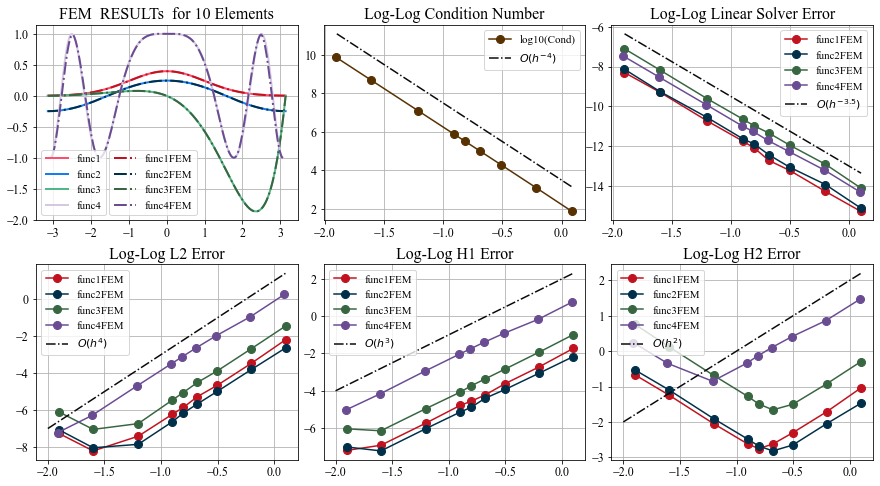

In [50]:
# Error Visualization 
fig, axes = plt.subplots( 2 , 3 , figsize=( 15 , 8 ) ) # figsize=( 12 , 10 )

# Plot FEM results in subplot(0,0)
xs = [ np.linspace(bound[0], bound[1], 500) for bound in bounds]
y_trues = [ u_trues[i](xs[i]) for i in range(4) ]
y_nums  = [ models[i].evaluate(xs[i])  for i in range(4) ]
trueColor = ['#ff4d6d','#147df5','#52b788','#d5c9df']
FEMColor = ['#c1121f','#003049','#386641','#6a4c93']

true_lines , num_lines = [] , []
for i in range(4):
    true_line, = axes[0,0].plot(xs[i], y_trues[i], linewidth=2, label=true_names[i], color=trueColor[i])
    num_line, = axes[0,0].plot(xs[i], y_nums[i]  , linestyle='-.', linewidth=2, label=model_names[i], color=FEMColor[i])
    
    true_lines.append(true_line)
    num_lines.append(num_line) 

# # Read in Error Data
# with open('DATA/ErrorAnalysis.pkl', 'rb') as file:
#     result = pickle.load(file)  
# ns  = result['ns']
# hs , L2s , H1s , H2s = result['hs'] , result['L2s'] , result['H1s'] , result['H2s'] 
# linalgErrors , Conds = result['linalgErrors'] , result['Conds']

# Plot Condition Number
axes[0,1].plot(np.log10(hs[i]), np.log10(Conds[0]), marker='o', markersize=8, label='log10(Cond)', color='#583101')
axes[0,1].plot(np.linspace(-1.9,0.1), -4*np.linspace(-1.9,0.1)+3.5, '-.', label=r'$O(h ^{-4})$', color='#0b090a') 

# Plot linalg Error
for i in range(4):
    axes[0,2].plot(np.log10(hs[i]), np.log10(linalgErrors[i]), marker='o', markersize=8, label=model_names[i], color=FEMColor[i])
    
axes[0,2].plot(np.linspace(-1.9,0.1), -3.5*np.linspace(-1.9,0.1)-13, '-.', label=r'$O(h ^{-3.5})$', color='#0b090a') # Reference line

# Plot L2 Error
for i in range(4):
    axes[1,0].plot(np.log10(hs[i]), np.log10(L2s[i]), marker='o', markersize=8, label=model_names[i], color=FEMColor[i])

axes[1,0].plot(np.linspace(-2,0.1), 4*np.linspace(-2,0.1)+1, '-.', label=r'$O(h ^4)$', color='#0b090a') # Reference line
    
# Plot H1 Error
for i in range(4):
    axes[1,1].plot(np.log10(hs[i]), np.log10(H1s[i]), marker='o', markersize=8, label=model_names[i], color=FEMColor[i])
    
axes[1,1].plot(np.linspace(-2,0.1), 3*np.linspace(-2,0.1)+2, '-.', label=r'$O(h ^3)$', color='#0b090a') # Reference line

# Plot H2 Error
for i in range(4):
    axes[1,2].plot(np.log10(hs[i]), np.log10(H2s[i]), marker='o', markersize=8, label=model_names[i], color=FEMColor[i])

axes[1,2].plot(np.linspace(-2,0.1), 2*np.linspace(-2,0.1)+2, '-.', label=r'$O(h ^2)$', color='#0b090a') # Reference line

# General Settings
title_fontsize = 16 # 15
tick_size = 12
leg_size = 11

for i in range(2):
    for j in range(3): 
        
        axes[i,j].grid() # Grid on
        
        # Tick size
        axes[i,j].tick_params(axis='x', labelsize=tick_size)
        axes[i,j].tick_params(axis='y', labelsize=tick_size)
        
        # Set legend
        if i==0 and j==0 :
            first_legend = axes[i,j].legend(handles=true_lines, loc='lower left', fontsize=leg_size, bbox_to_anchor=(0, 0))
            axes[i,j].add_artist(first_legend)
            axes[i,j].legend(handles=num_lines, loc='lower left', fontsize=leg_size, bbox_to_anchor=(0.26, 0))
        elif i==0 :
            axes[i,j].legend(loc='upper right', fontsize=leg_size, fancybox=True)
        else :
            axes[i,j].legend(loc='upper left', fontsize=leg_size, fancybox=True)

# Titles        
axes[0,0].set_title( 'FEM  RESULTs  for 10 Elements', fontsize = title_fontsize)
axes[0,1].set_title( 'Log-Log Condition Number', fontsize = title_fontsize)
axes[0,2].set_title( 'Log-Log Linear Solver Error', fontsize = title_fontsize)
axes[1,0].set_title( 'Log-Log L2 Error', fontsize = title_fontsize)
axes[1,1].set_title( 'Log-Log H1 Error', fontsize = title_fontsize)
axes[1,2].set_title( 'Log-Log H2 Error', fontsize = title_fontsize)


plt.subplots_adjust(wspace=0.1, hspace=0.225)
plt.show()

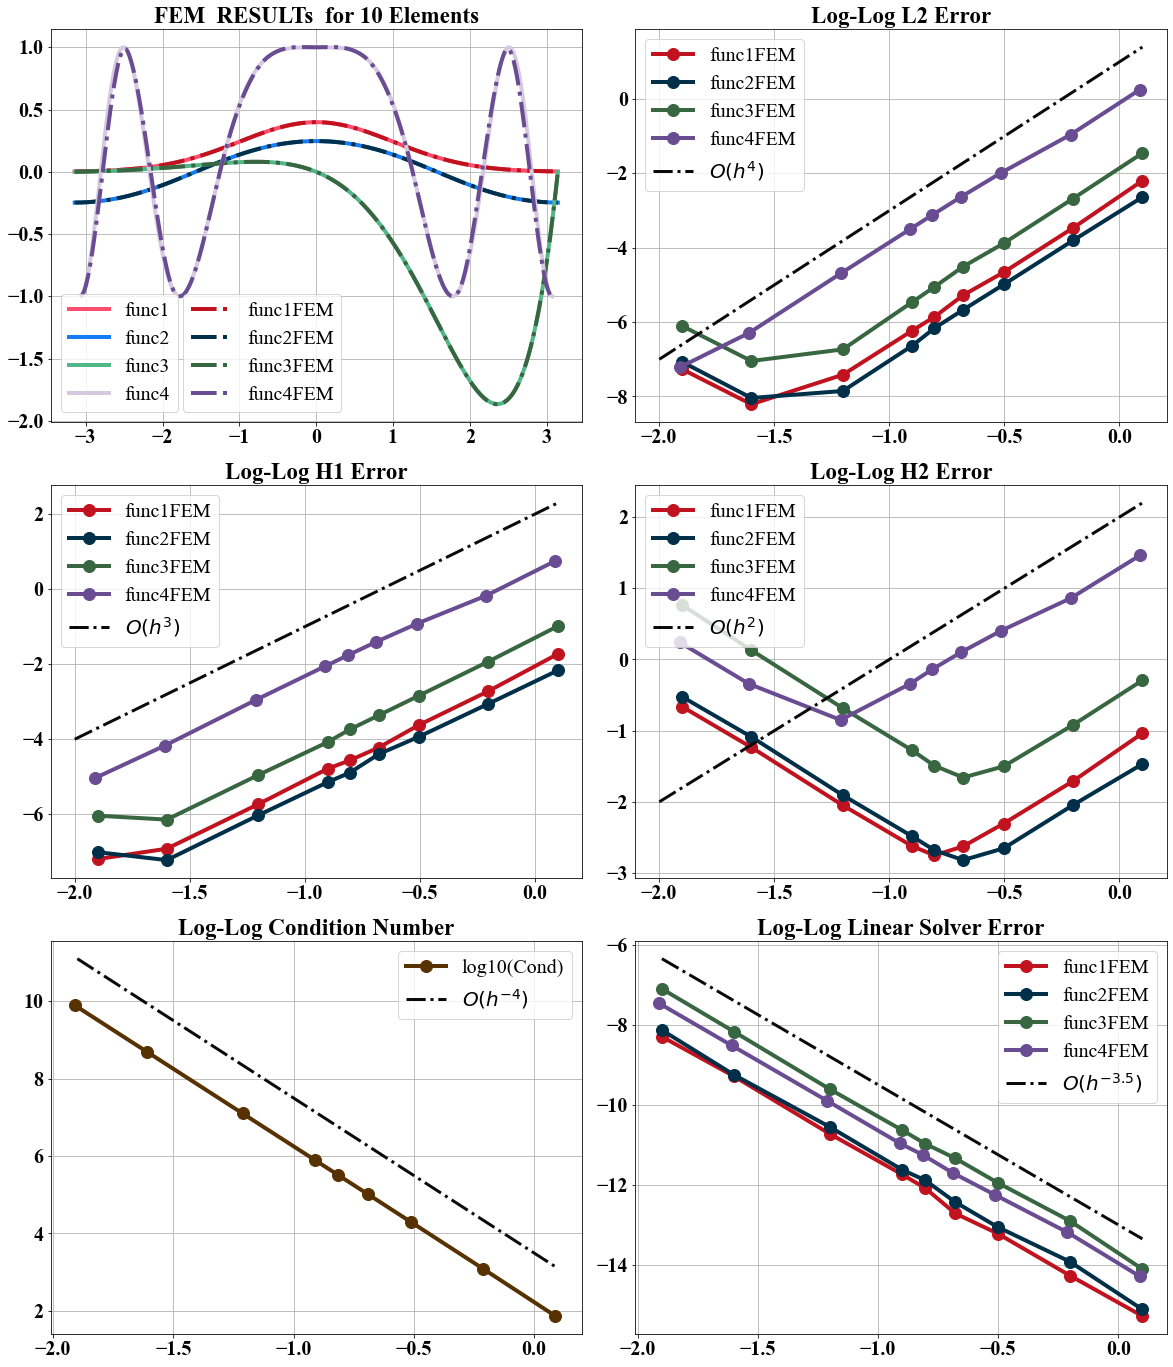

In [51]:
# Error Visualization 
fig, axes = plt.subplots( 3, 2 , figsize=( 20 , 24 ) ) # figsize=( 12 , 10 )

# Plot FEM results in subplot(0,0)
xs = [ np.linspace(bound[0], bound[1], 500) for bound in bounds]
y_trues = [ u_trues[i](xs[i]) for i in range(4) ]
y_nums  = [ models[i].evaluate(xs[i])  for i in range(4) ]
trueColor = ['#ff4d6d','#147df5','#52b788','#d5c9df']
FEMColor = ['#c1121f','#003049','#386641','#6a4c93']

true_lines , num_lines = [] , []
for i in range(4):
    true_line, = axes[0,0].plot(xs[i], y_trues[i], linewidth=4, label=true_names[i], color=trueColor[i])
    num_line, = axes[0,0].plot(xs[i], y_nums[i]  , linestyle='-.', linewidth=4, label=model_names[i], color=FEMColor[i])
    
    true_lines.append(true_line)
    num_lines.append(num_line) 

# # Read in Error Data
# with open('DATA/ErrorAnalysis.pkl', 'rb') as file:
#     result = pickle.load(file)  
# ns  = result['ns']
# hs , L2s , H1s , H2s = result['hs'] , result['L2s'] , result['H1s'] , result['H2s'] 
# linalgErrors , Conds = result['linalgErrors'] , result['Conds']


# Plot L2 Error
for i in range(4):
    axes[0,1].plot(np.log10(hs[i]), np.log10(L2s[i]), marker='o', linewidth=4, markersize=12, label=model_names[i], color=FEMColor[i])

axes[0,1].plot(np.linspace(-2,0.1), 4*np.linspace(-2,0.1)+1, '-.', label=r'$O(h ^4)$', color='#0b090a', linewidth=3) # Reference line
    
# Plot H1 Error
for i in range(4):
    axes[1,0].plot(np.log10(hs[i]), np.log10(H1s[i]), marker='o', linewidth=4, markersize=12, label=model_names[i], color=FEMColor[i])
    
axes[1,0].plot(np.linspace(-2,0.1), 3*np.linspace(-2,0.1)+2, '-.', label=r'$O(h ^3)$', color='#0b090a', linewidth=3) # Reference line

# Plot H2 Error
for i in range(4):
    axes[1,1].plot(np.log10(hs[i]), np.log10(H2s[i]), marker='o',  linewidth=4, markersize=12, label=model_names[i], color=FEMColor[i])

axes[1,1].plot(np.linspace(-2,0.1), 2*np.linspace(-2,0.1)+2, '-.', label=r'$O(h ^2)$', color='#0b090a', linewidth=3) # Reference line


# Plot Condition Number
axes[2,0].plot(np.log10(hs[i]), np.log10(Conds[0]), marker='o',  linewidth=4, markersize=12, label='log10(Cond)', color='#583101')
axes[2,0].plot(np.linspace(-1.9,0.1), -4*np.linspace(-1.9,0.1)+3.5, '-.', label=r'$O(h ^{-4})$', color='#0b090a', linewidth=3) 

# Plot linalg Error
for i in range(4):
    axes[2,1].plot(np.log10(hs[i]), np.log10(linalgErrors[i]), marker='o',  linewidth=4, markersize=12, label=model_names[i], color=FEMColor[i])
    
axes[2,1].plot(np.linspace(-1.9,0.1), -3.5*np.linspace(-1.9,0.1)-13, '-.', label=r'$O(h ^{-3.5})$', color='#0b090a', linewidth=3) # Reference line


# General Settings
title_fontsize = 23 # 15
tick_size = 20
leg_size = 20

for i in range(3):
    for j in range(2): 
        
        axes[i,j].grid() # Grid on
        
        # Tick size
        axes[i,j].tick_params(axis='x', labelsize=tick_size)
        axes[i,j].tick_params(axis='y', labelsize=tick_size)
        
        # Set legend
        if i==0 and j==0 :
            first_legend = axes[i,j].legend(handles=true_lines, loc='lower left', fontsize=leg_size, bbox_to_anchor=(0, 0))
            axes[i,j].add_artist(first_legend)
            axes[i,j].legend(handles=num_lines, loc='lower left', fontsize=leg_size, bbox_to_anchor=(0.23, 0))
        elif i==2 :
            axes[i,j].legend(loc='upper right', fontsize=leg_size, fancybox=True)
        else :
            axes[i,j].legend(loc='upper left', fontsize=leg_size, fancybox=True)
            
        # Bold
        for label in (axes[i,j].get_xticklabels() + axes[i,j].get_yticklabels()):
            label.set_fontweight('bold')
        
        

# Titles        
axes[0,0].set_title( 'FEM  RESULTs  for 10 Elements', fontsize = title_fontsize, fontweight='bold')
axes[0,1].set_title( 'Log-Log L2 Error', fontsize = title_fontsize, fontweight='bold')
axes[1,0].set_title( 'Log-Log H1 Error', fontsize = title_fontsize, fontweight='bold')
axes[1,1].set_title( 'Log-Log H2 Error', fontsize = title_fontsize, fontweight='bold')
axes[2,0].set_title( 'Log-Log Condition Number', fontsize = title_fontsize, fontweight='bold')
axes[2,1].set_title( 'Log-Log Linear Solver Error', fontsize = title_fontsize, fontweight='bold')


plt.subplots_adjust(wspace=0.1, hspace=0.16)
plt.show()

# Discontinuos Force Functions

In [52]:
def ConstructDiscontExample(lb, ub, fl , fr, BC1, BC2) :
    # This function helps to constrct a class of dicontinuous examples for f = fl*(x<c) + fr*(x>=c) s.t. D^4u=f
    
    c , l = ( ub + lb ) / 2 , ( ub - lb ) / 2
    f = lambda x : fl*(x<c) + fr*(x>=c)  # f discontinuous at middle

    # Construct true solution
    coeffs = np.zeros(10)
    coeffs[[0,1,4,5,6,9]] = [BC1[0], BC2[0], fl/24, BC1[1], BC2[1], fr/24]

    M = np.array([[l**2, l**3  , -l**2, l**3   ],
                  [2*l , 3*l**2, 2*l  , -3*l**2],
                  [2   , 6*l   , -2   , 6*l    ],
                  [0   , 1     , 0    , -1     ]])

    b = np.array([ (coeffs[5]-coeffs[0]) - l*(coeffs[6]+coeffs[1]) + l**4*(coeffs[9]-coeffs[4]) ,
                (coeffs[6]-coeffs[1]) - 4*l**3*(coeffs[9]+coeffs[4]) ,
                12*l**2*(coeffs[9]-coeffs[4]) ,
                -4*l*(coeffs[9]+coeffs[4]) ])

    coeffs[[2,3,7,8]] = linalg.solve(M, b)

    ul = lambda x : (coeffs[:5] * (x-lb)**np.array([0,1,2,3,4])).sum()
    ur = lambda x : (coeffs[5:] * (x-ub)**np.array([0,1,2,3,4])).sum()
    u_true = lambda x : np.vectorize(ul)(x)*(x<c) + np.vectorize(ur)(x)*(x>=c)
    
    return u_true , coeffs , f

All above true solutions u belong to C3; f in L2 for the variational form.

In [59]:
# Setting parameters
# BCs
bounds = [ (-1,1) , (-1,1) , (-1,1) , (-1,1) , (-1,1) ]
BC1s   = [ (0,0) , (0.5,0.5) , (0,0)  , (0.5,-0.5)  ]
BC2s   = [ (0,0) , (0,0) , (1,-1) , (1,-1)  ]
flvsfr = [ (2,-2) , (1,2) , (-1,-2) , (3,4) ]

# Quadrature rule
quadRule = ('scipy_quad', 1.49e-15) # ('gaussLeg',4)

# Construct Examples
u_trues , coeffss , fs = [] , [] , []

for i in range(4):
    u_true , coeffs , f = ConstructDiscontExample(bounds[i][0], bounds[i][1], flvsfr[i][0] , flvsfr[i][1], BC1s[i], BC2s[i])
    u_trues.append(u_true)
    coeffss.append(coeffs)
    fs.append(f)

# Initialize models
models = [ BiharmonicSolver1D(fs[i], bounds[i][0], bounds[i][1], BC1s[i], BC2s[i], mesh=10, quadRule=quadRule) for i in range(4) ]
true_names = ['dfunc1', 'dfunc2', 'dfunc3', 'dfunc4']
model_names = ['dfunc1FEM', 'dfunc2FEM', 'dfunc3FEM', 'dfunc4FEM']

for i in range(4):
    models[i].fit()

In [60]:
# Calculate Errors
warnings.filterwarnings('ignore')
ns  = [ 5 , 10 , 15 , 20 , 25 , 30 , 35 , 40 ]
hs , L2s , H1s , H2s , linalgErrors , Conds = [] , [] , [] , [] , [] , []

for i in tqdm(range(4)):
    h_lst , L2_lst , H1_lst , H2_lst , linalgError_lst , Cond_lst = [] , [] , [] , [] , [] , []
    for n in tqdm(ns):
        temp_model = BiharmonicSolver1D(fs[i], bounds[i][0], bounds[i][1], BC1s[i], BC2s[i], mesh=n, quadRule=quadRule)
        temp_model.fit()
        
        h_lst.append(temp_model.meshSize)
        L2_lst.append(temp_model.approxError(u_trues[i], errortype = 'L2'))
        H1_lst.append(temp_model.approxError(u_trues[i], errortype = 'H1'))
        H2_lst.append(temp_model.approxError(u_trues[i], errortype = 'H2'))
        linalgError_lst.append(temp_model.linalgError)
        Cond_lst.append(temp_model.linalgCond)
        
    hs.append(h_lst)
    L2s.append(L2_lst)
    H1s.append(H1_lst)
    H2s.append(H2_lst)
    linalgErrors.append(linalgError_lst)
    Conds.append(Cond_lst)

hs = np.array(hs) 
L2s = np.array(L2s)
H1s = np.array(H1s)
H2s = np.array(H2s)

# Store data
with open( 'DATA/DiscontErrorAnalysis.pkl', 'wb') as file:
    pickle.dump({'ns':ns, 'hs':hs, 'L2s':L2s, 'H1s':H1s, "H2s":H2s, 'linalgErrors':linalgErrors, 'Conds':Conds}, file)

100%|██████████| 4/4 [02:13<00:00, 33.28s/it]


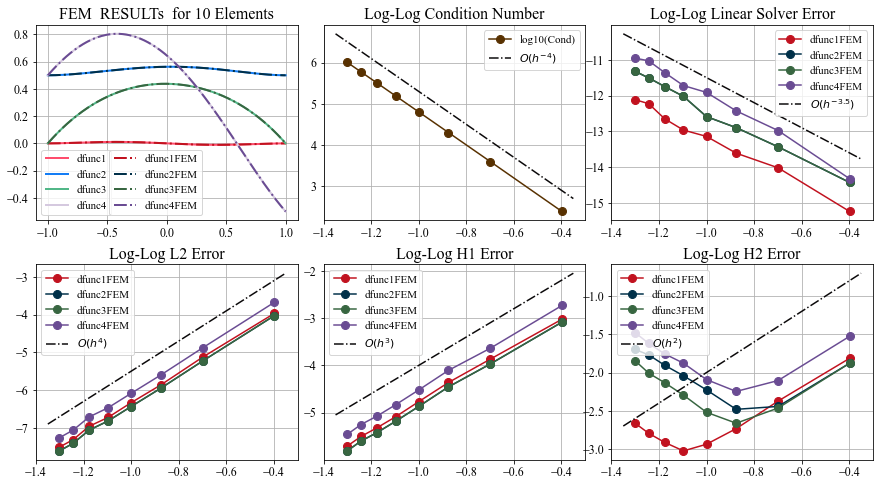

In [61]:
# Error Visualization 
fig, axes = plt.subplots( 2 , 3 , figsize=( 15 , 8 ) ) # figsize=( 12 , 10 )

# Plot FEM results in subplot(0,0)
xs = [ np.linspace(bound[0], bound[1], 500) for bound in bounds]
y_trues = [ u_trues[i](xs[i]) for i in range(4) ]
y_nums  = [ models[i].evaluate(xs[i])  for i in range(4) ]
trueColor = ['#ff4d6d','#147df5','#52b788','#d5c9df']
FEMColor = ['#c1121f','#003049','#386641','#6a4c93']
reference_x = np.linspace(-1.35,-0.35)

true_lines , num_lines = [] , []
for i in range(4):
    true_line, = axes[0,0].plot(xs[i], y_trues[i], linewidth=2, label=true_names[i], color=trueColor[i])
    num_line, = axes[0,0].plot(xs[i], y_nums[i]  , linestyle='-.', linewidth=2, label=model_names[i], color=FEMColor[i])
    
    true_lines.append(true_line)
    num_lines.append(num_line) 

# # Read in Error Data
# with open('DATA/DiscontErrorAnalysis.pkl', 'rb') as file:
#     result = pickle.load(file)  
# ns  = result['ns']
# hs , L2s , H1s , H2s = result['hs'] , result['L2s'] , result['H1s'] , result['H2s'] 
# linalgErrors , Conds = result['linalgErrors'] , result['Conds']

# Plot Condition Number
axes[0,1].plot(np.log10(hs[i]), np.log10(Conds[0]), marker='o', markersize=8, label='log10(Cond)', color='#583101')
axes[0,1].plot(reference_x, -4*reference_x+1.3, '-.', label=r'$O(h ^{-4})$', color='#0b090a') 

# Plot linalg Error
for i in range(4):
    axes[0,2].plot(np.log10(hs[i]), np.log10(linalgErrors[i]), marker='o', markersize=8, label=model_names[i], color=FEMColor[i])
    
axes[0,2].plot(reference_x, -3.5*reference_x-15, '-.', label=r'$O(h ^{-3.5})$', color='#0b090a') # Reference line

# Plot L2 Error
for i in range(4):
    axes[1,0].plot(np.log10(hs[i]), np.log10(L2s[i]), marker='o', markersize=8, label=model_names[i], color=FEMColor[i])

axes[1,0].plot(reference_x, 4*reference_x-1.5, '-.', label=r'$O(h ^4)$', color='#0b090a') # Reference line
    
# Plot H1 Error
for i in range(4):
    axes[1,1].plot(np.log10(hs[i]), np.log10(H1s[i]), marker='o', markersize=8, label=model_names[i], color=FEMColor[i])
    
axes[1,1].plot(reference_x, 3*reference_x-1, '-.', label=r'$O(h ^3)$', color='#0b090a') # Reference line

# Plot H2 Error
for i in range(4):
    axes[1,2].plot(np.log10(hs[i]), np.log10(H2s[i]), marker='o', markersize=8, label=model_names[i], color=FEMColor[i])

axes[1,2].plot(reference_x, 2*reference_x, '-.', label=r'$O(h ^2)$', color='#0b090a') # Reference line

# General Settings
title_fontsize = 16 # 15
tick_size = 12
leg_size = 11

for i in range(2):
    for j in range(3): 
        
        axes[i,j].grid() # Grid on
        
        # Tick size
        axes[i,j].tick_params(axis='x', labelsize=tick_size)
        axes[i,j].tick_params(axis='y', labelsize=tick_size)
        
        # Set legend
        if i==0 and j==0 :
            first_legend = axes[i,j].legend(handles=true_lines, loc='lower left', fontsize=leg_size, bbox_to_anchor=(0, 0))
            axes[i,j].add_artist(first_legend)
            axes[i,j].legend(handles=num_lines, loc='lower left', fontsize=leg_size, bbox_to_anchor=(0.26, 0))
        elif i==0 :
            axes[i,j].legend(loc='upper right', fontsize=leg_size, fancybox=True)
        else :
            axes[i,j].legend(loc='upper left', fontsize=leg_size, fancybox=True)

# Titles        
axes[0,0].set_title( 'FEM  RESULTs  for 10 Elements', fontsize = title_fontsize)
axes[0,1].set_title( 'Log-Log Condition Number', fontsize = title_fontsize)
axes[0,2].set_title( 'Log-Log Linear Solver Error', fontsize = title_fontsize)
axes[1,0].set_title( 'Log-Log L2 Error', fontsize = title_fontsize)
axes[1,1].set_title( 'Log-Log H1 Error', fontsize = title_fontsize)
axes[1,2].set_title( 'Log-Log H2 Error', fontsize = title_fontsize)


plt.subplots_adjust(wspace=0.1, hspace=0.225)
plt.show()

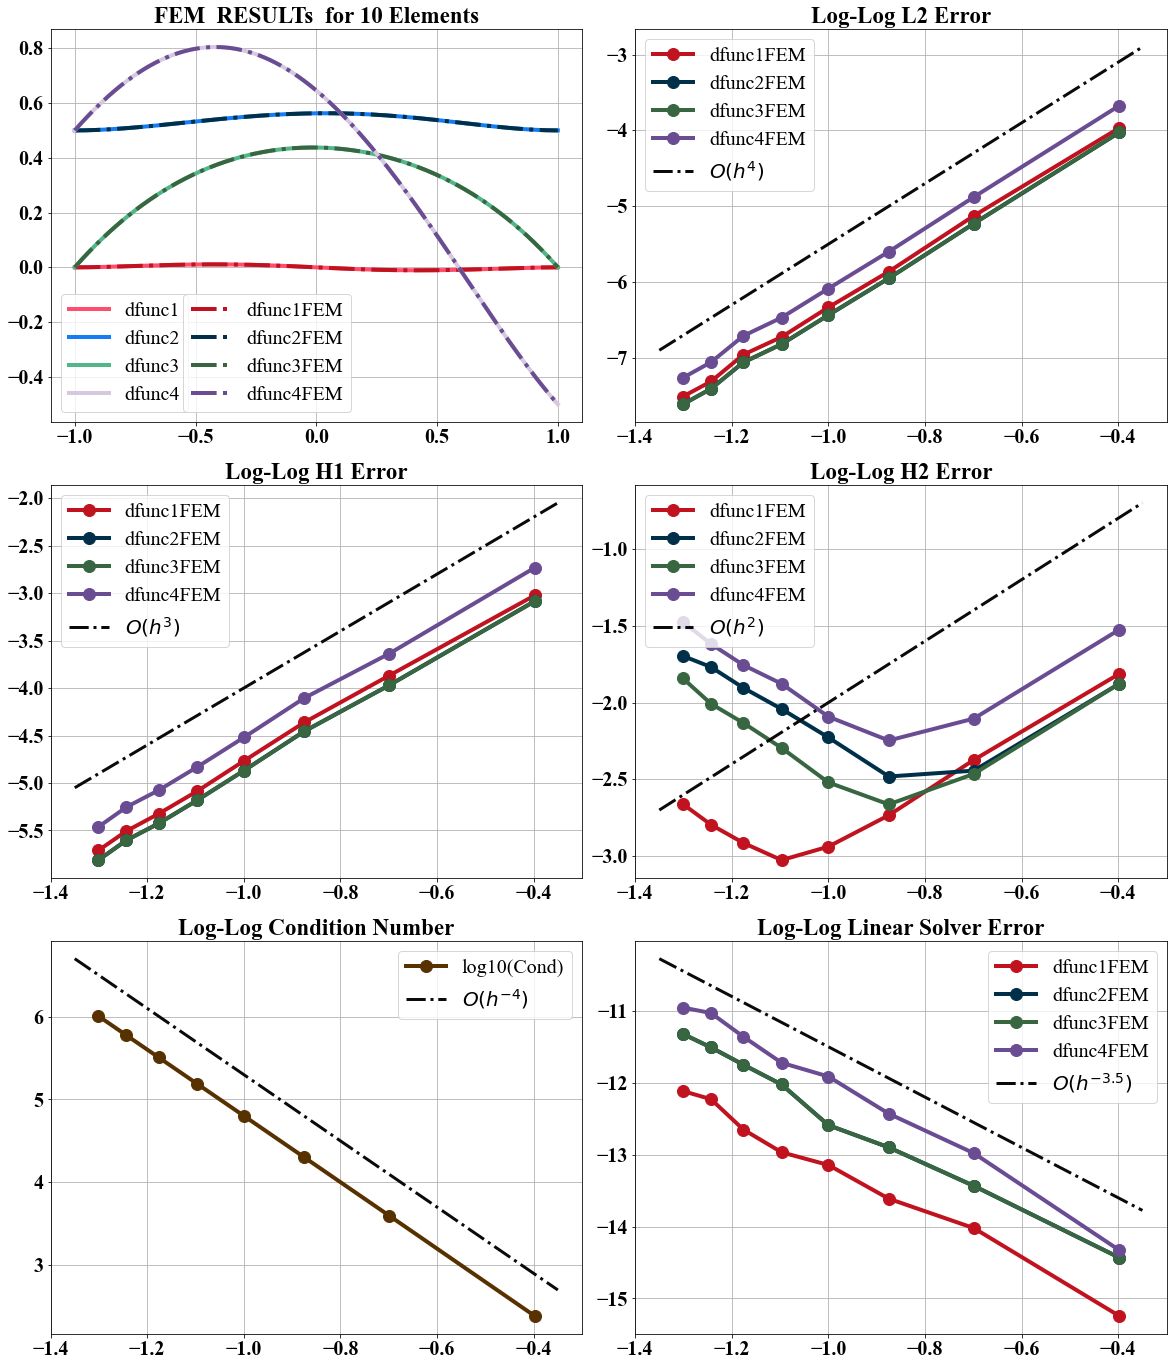

In [62]:
# Error Visualization 
fig, axes = plt.subplots( 3, 2 , figsize=( 20 , 24 ) ) # figsize=( 12 , 10 )

# Plot FEM results in subplot(0,0)
xs = [ np.linspace(bound[0], bound[1], 500) for bound in bounds]
y_trues = [ u_trues[i](xs[i]) for i in range(4) ]
y_nums  = [ models[i].evaluate(xs[i])  for i in range(4) ]
trueColor = ['#ff4d6d','#147df5','#52b788','#d5c9df']
FEMColor = ['#c1121f','#003049','#386641','#6a4c93']
reference_x = np.linspace(-1.35,-0.35)


true_lines , num_lines = [] , []
for i in range(4):
    true_line, = axes[0,0].plot(xs[i], y_trues[i], linewidth=4, label=true_names[i], color=trueColor[i])
    num_line, = axes[0,0].plot(xs[i], y_nums[i]  , linestyle='-.', linewidth=4, label=model_names[i], color=FEMColor[i])
    
    true_lines.append(true_line)
    num_lines.append(num_line) 

# # Read in Error Data
# with open('DATA/ErrorAnalysis.pkl', 'rb') as file:
#     result = pickle.load(file)  
# ns  = result['ns']
# hs , L2s , H1s , H2s = result['hs'] , result['L2s'] , result['H1s'] , result['H2s'] 
# linalgErrors , Conds = result['linalgErrors'] , result['Conds']


# Plot L2 Error
for i in range(4):
    axes[0,1].plot(np.log10(hs[i]), np.log10(L2s[i]), marker='o', linewidth=4, markersize=12, label=model_names[i], color=FEMColor[i])

axes[0,1].plot(reference_x, 4*reference_x-1.5, '-.', label=r'$O(h ^4)$', color='#0b090a', linewidth=3) # Reference line
    
# Plot H1 Error
for i in range(4):
    axes[1,0].plot(np.log10(hs[i]), np.log10(H1s[i]), marker='o', linewidth=4, markersize=12, label=model_names[i], color=FEMColor[i])
    
axes[1,0].plot(reference_x, 3*reference_x-1, '-.', label=r'$O(h ^3)$', color='#0b090a', linewidth=3) # Reference line

# Plot H2 Error
for i in range(4):
    axes[1,1].plot(np.log10(hs[i]), np.log10(H2s[i]), marker='o',  linewidth=4, markersize=12, label=model_names[i], color=FEMColor[i])

axes[1,1].plot(reference_x, 2*reference_x, '-.', label=r'$O(h ^2)$', color='#0b090a', linewidth=3) # Reference line


# Plot Condition Number
axes[2,0].plot(np.log10(hs[i]), np.log10(Conds[0]), marker='o',  linewidth=4, markersize=12, label='log10(Cond)', color='#583101')
axes[2,0].plot(reference_x, -4*reference_x+1.3, '-.', label=r'$O(h ^{-4})$', color='#0b090a', linewidth=3) 

# Plot linalg Error
for i in range(4):
    axes[2,1].plot(np.log10(hs[i]), np.log10(linalgErrors[i]), marker='o',  linewidth=4, markersize=12, label=model_names[i], color=FEMColor[i])
    
axes[2,1].plot(reference_x, -3.5*reference_x-15, '-.', label=r'$O(h ^{-3.5})$', color='#0b090a', linewidth=3) # Reference line


# General Settings
title_fontsize = 23 # 15
tick_size = 20
leg_size = 20

for i in range(3):
    for j in range(2): 
        
        axes[i,j].grid() # Grid on
        
        # Tick size
        axes[i,j].tick_params(axis='x', labelsize=tick_size)
        axes[i,j].tick_params(axis='y', labelsize=tick_size)
        
        # Set legend
        if i==0 and j==0 :
            first_legend = axes[i,j].legend(handles=true_lines, loc='lower left', fontsize=leg_size, bbox_to_anchor=(0, 0))
            axes[i,j].add_artist(first_legend)
            axes[i,j].legend(handles=num_lines, loc='lower left', fontsize=leg_size, bbox_to_anchor=(0.23, 0))
        elif i==2 :
            axes[i,j].legend(loc='upper right', fontsize=leg_size, fancybox=True)
        else :
            axes[i,j].legend(loc='upper left', fontsize=leg_size, fancybox=True)
            
        # Bold
        for label in (axes[i,j].get_xticklabels() + axes[i,j].get_yticklabels()):
            label.set_fontweight('bold')
        
        

# Titles        
axes[0,0].set_title( 'FEM  RESULTs  for 10 Elements', fontsize = title_fontsize, fontweight='bold')
axes[0,1].set_title( 'Log-Log L2 Error', fontsize = title_fontsize, fontweight='bold')
axes[1,0].set_title( 'Log-Log H1 Error', fontsize = title_fontsize, fontweight='bold')
axes[1,1].set_title( 'Log-Log H2 Error', fontsize = title_fontsize, fontweight='bold')
axes[2,0].set_title( 'Log-Log Condition Number', fontsize = title_fontsize, fontweight='bold')
axes[2,1].set_title( 'Log-Log Linear Solver Error', fontsize = title_fontsize, fontweight='bold')


plt.subplots_adjust(wspace=0.1, hspace=0.16)
plt.show()